# Network Analysis Using KGTK and graph-tool

In this part of the tutorial you will learn how to do network analysis on a knowledge graph using KGTK and graph-tool (https://graph-tool.skewed.de/), a library for efficient network analysis on large networks. The typical network analysis workflow first extracts a network of interest from a KG, and then applies network analysis tools to the extracted network. KGTK is useful to extract the network as extraction of networks is often an expensive operation on large KGs. KGTK also provides basic, commonly used network analytics (pagerank, connected components, reachability and paths), and can export the networks into the format required by graph-tool, which supports a wide selection onf sophisticated network analytics algorithms (e.g., community detection).

This tutorial is divided into multiple subsections:
- Computing network metrics on the original graph
- Extracting a network of interest from our KG (the extended family of Arnold Schwarzenegger)
- Computing network analytics on the Arnold family graph
- Creating visualizations of KGs using graph-tools
- Computing connected components of a KG

## Step 0: Install KGTK

Only run the following cell if KGTK is not installed.
 For example, if running in [Google Colab](https://colab.research.google.com/)

In [ ]:
!pip install kgtk

**Run the following cell only in Google Golab, to install graph-tool. There is no conda installed in google colab, so we install it using apt-get**

In [ ]:
!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-cairo python3-matplotlib
!apt-get install libcairo2-dev 

## Preamble: set up the environment and files used in the tutorial

In [1]:
import io
import os
import sys

from kgtk.configure_kgtk_notebooks import ConfigureKGTK
from kgtk.functions import kgtk, kypher

In [2]:
# Parameters

input_path = None

output_path = "/tmp/projects"
project_name = "tutorial-network-analysis"

input_files_url = "https://github.com/usc-isi-i2/kgtk-tutorial-files/raw/main/datasets/arnold-profiled"

These are all the files that we have, but I am tempted to just use the `all` file as it helps to keep the tutorial simpler

In [3]:
files = [
    "label",
    "item",
    "time",
    "quantity"
]
ck = ConfigureKGTK(files, input_files_url=input_files_url)
ck.configure_kgtk(input_graph_path=input_path,
                  output_path=output_path,
                  project_name=project_name)

User home: /Users/amandeep
Current dir: /Users/amandeep/Github/kgtk-notebooks/tutorial
KGTK dir: /Users/amandeep/Github/kgtk-notebooks
Use-cases dir: /Users/amandeep/Github/kgtk-notebooks/use-cases
--2022-04-29 15:36:24--  https://github.com/usc-isi-i2/kgtk-tutorial-files/raw/main/datasets/arnold-profiled/labels.en.tsv.gz
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/usc-isi-i2/kgtk-notebooks/raw/main/datasets/arnold-profiled/labels.en.tsv.gz [following]
--2022-04-29 15:36:24--  https://github.com/usc-isi-i2/kgtk-notebooks/raw/main/datasets/arnold-profiled/labels.en.tsv.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/usc-isi-i2/kgtk-notebooks/main/datasets/arnold-profiled/labels.en.tsv.gz [following]
--2022-04-29 15:36:25--  http

In [4]:
ck.print_env_variables()

EXAMPLES_DIR: /Users/amandeep/Github/kgtk-notebooks/examples
KGTK_OPTION_DEBUG: false
kgtk: kgtk
KGTK_LABEL_FILE: /Users/amandeep/isi-kgtk-tutorial/tutorial-network-analysis_input/labels.en.tsv.gz
GRAPH: /Users/amandeep/isi-kgtk-tutorial/tutorial-network-analysis_input
USE_CASES_DIR: /Users/amandeep/Github/kgtk-notebooks/use-cases
OUT: /tmp/projects/tutorial-network-analysis
KGTK_GRAPH_CACHE: /tmp/projects/tutorial-network-analysis/temp.tutorial-network-analysis/wikidata.sqlite3.db
TEMP: /tmp/projects/tutorial-network-analysis/temp.tutorial-network-analysis
kypher: kgtk query --graph-cache /tmp/projects/tutorial-network-analysis/temp.tutorial-network-analysis/wikidata.sqlite3.db
STORE: /tmp/projects/tutorial-network-analysis/temp.tutorial-network-analysis/wikidata.sqlite3.db
label: /Users/amandeep/isi-kgtk-tutorial/tutorial-network-analysis_input/labels.en.tsv.gz
item: /Users/amandeep/isi-kgtk-tutorial/tutorial-network-analysis_input/claims.wikibase-item.tsv.gz
time: /Users/amandeep/is

Load all my files into the kypher cache so that all graph aliases are defined

In [5]:
%%time
ck.load_files_into_cache()

kgtk query --graph-cache /tmp/projects/tutorial-network-analysis/temp.tutorial-network-analysis/wikidata.sqlite3.db -i "/Users/amandeep/isi-kgtk-tutorial/tutorial-network-analysis_input/labels.en.tsv.gz" --as label  -i "/Users/amandeep/isi-kgtk-tutorial/tutorial-network-analysis_input/claims.wikibase-item.tsv.gz" --as item  -i "/Users/amandeep/isi-kgtk-tutorial/tutorial-network-analysis_input/claims.time.tsv.gz" --as time  -i "/Users/amandeep/isi-kgtk-tutorial/tutorial-network-analysis_input/claims.quantity.tsv.gz" --as quantity  --limit 3
node1	label	node2	id
P10	label	'video'@en	P10-label-en
P1000	label	'record held'@en	P1000-label-en
P1001	label	'applies to jurisdiction'@en	P1001-label-en
CPU times: user 6.08 ms, sys: 11.8 ms, total: 17.9 ms
Wall time: 5.59 s


# Compute network metrics on the original graph

Pagerank centrality is one of the most useful network metrics as we can use it to rank the results of queries. You can compute pagerank on a KG using the KGTK `graph-statistics` command. We are going to compute pagerank on the KG graph containing items only (no literals or qualifiers) because in our experience we get good results on this subgraph and the algorithm runs faster. 
> You can replace `$item` by `$all` and compute pagerank on the whole graph.

The `graph-statistics` command can also compute in/out degree and hits centrality. In the invocation below we turn off computation of `hits` as it takes longer. You can also specify the properties to be used to construct the graph containing your graph statistics. We are also treating the graph as undirected, as in our experience the pagerank results are more intuitive on the undirected graph:

In [6]:
%%time
kgtk("""
    graph-statistics -i "$item" -o $OUT/metadata.pagerank.undirected.tsv.gz 
    --compute-pagerank True 
    --compute-hits False 
    --page-rank-property Pdirected_pagerank 
    --vertex-in-degree-property Pindegree
    --vertex-out-degree-property Poutdegree
    --output-degrees True 
    --output-pagerank True 
    --output-hits False \
    --output-statistics-only 
    --undirected True 
    --log-file $TEMP/metadata.pagerank.undirected.summary.txt
""")

CPU times: user 7.16 ms, sys: 12.4 ms, total: 19.6 ms
Wall time: 11.1 s


The output is a KG, and is represented using the usual `node1/label/node2/id` TSV file:

In [7]:
kgtk("""
    head -i $OUT/metadata.pagerank.undirected.tsv.gz
""")

,node1,label,node2,id
0,P10,Pindegree,0.000000,P10-Pindegree-0
1,P10,Poutdegree,1.000000,P10-Poutdegree-1
2,P10,Pdirected_pagerank,0.000005,P10-Pdirected_pagerank-2
3,Q18610173,Pindegree,0.000000,Q18610173-Pindegree-3
4,Q18610173,Poutdegree,18.000000,Q18610173-Poutdegree-4
5,Q18610173,Pdirected_pagerank,0.000056,Q18610173-Pdirected_pagerank-5
6,P1000,Pindegree,0.000000,P1000-Pindegree-6
7,P1000,Poutdegree,1.000000,P1000-Poutdegree-7
8,P1000,Pdirected_pagerank,0.000004,P1000-Pdirected_pagerank-8
9,Q18608871,Pindegree,0.000000,Q18608871-Pindegree-9


Now that we have a graph with pagerank information, we can use it in any query to rank the results by pagerank. 
The following query retrieves all `instance of (P31)` of `human (Q5)` from the `item` graph and uses the `pagerank` graph to rank the results by pagerank:

In [8]:
%%time
kgtk("""
    query -i item -i $OUT/metadata.pagerank.undirected.tsv.gz
        --match '
            item: (human)-[:P31]->(:Q5),
            pagerank: (human)-[:Pdirected_pagerank]->(pagerank)'
        --return 'human as node1, pagerank as node2'
        --order-by 'cast(pagerank, float) desc'
    / add-labels
""")

CPU times: user 67.9 ms, sys: 22.1 ms, total: 89.9 ms
Wall time: 5.07 s


,node1,node2,node1;label
0,Q22686,0.000135,'Donald Trump'@en
1,Q76,0.000131,'Barack Obama'@en
2,Q11812,0.000113,'Thomas Jefferson'@en
3,Q9916,0.000108,'Dwight D. Eisenhower'@en
4,Q23505,0.000104,'George H. W. Bush'@en
...,...,...,...
13866,Q99850,0.000004,'Hu Yaobang'@en
13867,Q99885632,0.000004,'Jean-Marc Gayraud'@en
13868,Q99887066,0.000004,'Gilbert Narcisse'@en
13869,Q999332,0.000004,'Buck Henry'@en


## Create a network of the extended family of `Arnold Schwarzenegger (Q2685)`
We will use the following properties to build the network:
- `child (P40)`
- `sibling (P3373)`
- `spouse (P26)`
- `unmarried partner (P451)`
- `father (P22)`
- `mother (P25)`

And we will exclude:
- `relative (P1038)` (exclude)

Approach:
- Starting from `Arnold Schwarzenegger (Q2685)` find all the nodes that can be reached using the properties listed above
- Extract from the KG all the edges any two nodes computed in the previous step.

> Note: the `reachable-nodes` command only reports nodes, so we have to use the two steps as described above.

The `reachable-nodes` command can compute all the nodes reachable from a set of roots. The roots can be supplied in the command line, and for bulk processing, the root nodes can be specified in a file (it is possible to specify millions of root nodes).

In [9]:
%%time
kgtk("""
    reachable-nodes -i $item
        --root Q2685
        --props P40 P3373 P26 P451 P22 P25
        --label Pextended_family
    / add-labels
""")

CPU times: user 6.7 ms, sys: 11.4 ms, total: 18 ms
Wall time: 3.43 s


,node1,label,node2,node1;label,node2;label
0,Q2685,Pextended_family,Q3288486,'Arnold Schwarzenegger'@en,'Gustav Schwarzenegger'@en
1,Q2685,Pextended_family,Q23800370,'Arnold Schwarzenegger'@en,'Aurelia Schwarzenegger'@en
2,Q2685,Pextended_family,Q96076900,'Arnold Schwarzenegger'@en,'Jadrny'@en
3,Q2685,Pextended_family,Q38196234,'Arnold Schwarzenegger'@en,'Meinhard Schwarzenegger'@en
4,Q2685,Pextended_family,Q24004771,'Arnold Schwarzenegger'@en,'Patrick M. Knapp Schwarzenegger'@en
...,...,...,...,...,...
67,Q2685,Pextended_family,Q43100988,'Arnold Schwarzenegger'@en,'Jack Pratt'@en
68,Q2685,Pextended_family,Q901541,'Arnold Schwarzenegger'@en,'Patrick Schwarzenegger'@en
69,Q2685,Pextended_family,Q23800185,'Arnold Schwarzenegger'@en,'Joseph Baena'@en
70,Q2685,Pextended_family,Q75494768,'Arnold Schwarzenegger'@en,'Mildred Patricia Baena'@en


The extended family of Arnold Schwarzenegger in the tutorial KG contains 71 people. 
We store the nodes as a new graph so that it can be used in other KGTK commands:

In [10]:
%%time
kgtk("""
    reachable-nodes -i $item
        --root Q2685
        --props P40 P3373 P26 P451 P22 P25
        --label Pextended_family
        --selflink True
    -o $TEMP/arnold_family_members.tsv
""")

CPU times: user 3.93 ms, sys: 10.5 ms, total: 14.5 ms
Wall time: 1.97 s


In step 2 we extract the edges that connect nodes in the set of reachable nodes. The `where` clause excludes the `relative (P1038)` property:

In [11]:
kgtk("""
    query -i item -i $TEMP/arnold_family_members.tsv
        --match '
            item: (n1)-[l {label: property}]->(n2),
            arnold: ()-[]->(n1),
            arnold: ()-[]->(n2)'
        --where 'property != "P1038"'
        --return 'distinct n1 as node1, property as label, n2 as node2'
    / add-labels
""")

,node1,label,node2,node1;label,label;label,node2;label
0,Q1086823,P22,Q345517,'Christopher Lawford'@en,'father'@en,'Peter Lawford'@en
1,Q1086823,P25,Q432694,'Christopher Lawford'@en,'mother'@en,'Patricia Kennedy Lawford'@en
2,Q1086823,P26,Q75326809,'Christopher Lawford'@en,'spouse'@en,'Jean Edith Olssen'@en
3,Q1086823,P3373,Q75326777,'Christopher Lawford'@en,'sibling'@en,'Victoria Lawford'@en
4,Q1086823,P3373,Q75326779,'Christopher Lawford'@en,'sibling'@en,'Sydney Lawford'@en
...,...,...,...,...,...,...
489,Q9696,P40,Q230303,'John F. Kennedy'@en,'child'@en,'Caroline Kennedy'@en
490,Q9696,P40,Q316064,'John F. Kennedy'@en,'child'@en,'John F. Kennedy Jr.'@en
491,Q9696,P40,Q3290402,'John F. Kennedy'@en,'child'@en,'Patrick Bouvier Kennedy'@en
492,Q9696,P40,Q75326753,'John F. Kennedy'@en,'child'@en,'Arabelle Kennedy'@en


Save the Arnold family in graph `arnold_family`:

In [12]:
%%time
kgtk("""
    query -i item -i $TEMP/arnold_family_members.tsv
        --match '
            item: (n1)-[l {label: property}]->(n2),
            arnold: ()-[]->(n1),
            arnold: ()-[]->(n2)'
        --where 'property != "P1038"'
        --return 'distinct n1 as node1, property as label, n2 as node2'
    / add-id --id-style wikidata
    -o $OUT/arnold.family.tsv
""")

kgtk("query -i $OUT/arnold.family.tsv --as arnold_family --limit 10")

Exception in thread background thread for pid 50120:
Traceback (most recent call last):
  File "/Users/amandeep/anaconda3/envs/kgtk-env/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/Users/amandeep/anaconda3/envs/kgtk-env/lib/python3.9/threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/amandeep/anaconda3/envs/kgtk-env/lib/python3.9/site-packages/sh.py", line 1683, in wrap
    fn(*rgs, **kwargs)
  File "/Users/amandeep/anaconda3/envs/kgtk-env/lib/python3.9/site-packages/sh.py", line 2662, in background_thread
    handle_exit_code(exit_code)
  File "/Users/amandeep/anaconda3/envs/kgtk-env/lib/python3.9/site-packages/sh.py", line 2349, in fn
    return self.command.handle_command_exit_code(exit_code)
  File "/Users/amandeep/anaconda3/envs/kgtk-env/lib/python3.9/site-packages/sh.py", line 905, in handle_command_exit_code
    raise exc
sh.ErrorReturnCode_1: 

  RAN: /bin/bash -c 'kgtk query -i $OUT/arnold.family.t

input alias 'arnold_family' already in use

CPU times: user 11.7 ms, sys: 20.3 ms, total: 32 ms
Wall time: 3.96 s


### Summary of this section:
In this section:
- We illustrated how to extract a network from a KG focusing on specific relations.
- We built a KG with the family memebers of Arnold.

## Do analytics on the Arnold family graph

In this part of the tutorial we show how to use KGTK to find paths between nodes. We will use the family network we built in the previous step. We specify the source and destination nodes for the paths also as a graph, which in general can be the output of other KGTK commands. Here we built a custom file to provide a few source and destination nodes: 
> We need a nicer way to provide a portable way to define the `path-query` file so that folks can edit it.

In [13]:
%%bash
cat <<EOF >$TEMP/path-query.tsv
node1	node2	label
Q2685	Q4616	path
Q9696	Q230303	path
Q75326777	Q4616	path
Q5112377	Q38196234	path
EOF

Add labels to the path file to confirm that our input is what we want:

In [14]:
kgtk("""
    add-labels -i $TEMP/path-query.tsv
""")

,node1,node2,label,node1;label,node2;label
0,Q2685,Q4616,path,'Arnold Schwarzenegger'@en,'Marilyn Monroe'@en
1,Q9696,Q230303,path,'John F. Kennedy'@en,'Caroline Kennedy'@en
2,Q75326777,Q4616,path,'Victoria Lawford'@en,'Marilyn Monroe'@en
3,Q5112377,Q38196234,path,'Christopher G. Kennedy'@en,'Meinhard Schwarzenegger'@en


We invoke the `paths` command to find the shortest paths between `node1` and `node2`:

In [15]:
kgtk("""
    paths -i $OUT/arnold.family.tsv
        --verbose False
        --shortest-path True
        --statistics-only True
        --path-file $TEMP/path-query.tsv
    -o $TEMP/path-results.tsv
""")

In [16]:
!head $TEMP/path-results.tsv

node1	label	node2	id
p0	0	Q2685-P26-Q230654	p0-0-0
p0	1	Q230654-P25-Q272908	p0-1-1
p0	2	Q272908-P3373-Q9696	p0-2-2
p0	3	Q9696-P451-Q4616	p0-3-3
p1	0	Q9696-P40-Q230303	p1-0-4
p2	0	Q75326777-P25-Q432694	p2-0-5
p2	1	Q432694-P3373-Q9696	p2-1-6
p2	2	Q9696-P451-Q4616	p2-2-7
p3	0	Q5112377-P22-Q25310	p3-0-8


In the output from the `paths` command, `node1` contains an identifier for a path, `node2` contains the edge identifier in the input graph, and `label` contains an integer to order the edges in the path.

The next command uses a query to retrieve the `node1, label, node2` for each of the edges in the paths. We pipe the results through `add-labels` to help us interpret the results.

In [17]:
kgtk("""
    query -i arnold_family -i $TEMP/path-results.tsv
        --match '
            path: (path)-[segment]->(edge),
            arnold_family: (n1)-[edge {label: property}]->(n2)'
        --return 'n1 as node1, property as label, n2 as node2, path as path, segment as segment'
        --order-by 'path, segment'
    / add-labels
""")

,node1,label,node2,path,segment,node1;label,label;label,node2;label
0,Q2685,P26,Q230654,p0,p0-0-0,'Arnold Schwarzenegger'@en,'spouse'@en,'Maria Shriver'@en
1,Q230654,P25,Q272908,p0,p0-1-1,'Maria Shriver'@en,'mother'@en,'Eunice Kennedy Shriver'@en
2,Q272908,P3373,Q9696,p0,p0-2-2,'Eunice Kennedy Shriver'@en,'sibling'@en,'John F. Kennedy'@en
3,Q9696,P451,Q4616,p0,p0-3-3,'John F. Kennedy'@en,'unmarried partner'@en,'Marilyn Monroe'@en
4,Q9696,P40,Q230303,p1,p1-0-4,'John F. Kennedy'@en,'child'@en,'Caroline Kennedy'@en
5,Q75326777,P25,Q432694,p2,p2-0-5,'Victoria Lawford'@en,'mother'@en,'Patricia Kennedy Lawford'@en
6,Q432694,P3373,Q9696,p2,p2-1-6,'Patricia Kennedy Lawford'@en,'sibling'@en,'John F. Kennedy'@en
7,Q9696,P451,Q4616,p2,p2-2-7,'John F. Kennedy'@en,'unmarried partner'@en,'Marilyn Monroe'@en
8,Q5112377,P22,Q25310,p3,p3-0-8,'Christopher G. Kennedy'@en,'father'@en,'Robert F. Kennedy'@en
9,Q25310,P3373,Q272908,p3,p3-1-9,'Robert F. Kennedy'@en,'sibling'@en,'Eunice Kennedy Shriver'@en


### Visualization of the Arnold family graph

Add labels for property Pnodes

In [18]:
kgtk(f"""query -i $OUT/arnold.family.tsv -i label --force
         --match 'family: (n1)-[l {{label: property}}]->(n2),
                  label: (property)-[]->(p_label)'
         --return 'n1 as node1, kgtk_lqstring_text(p_label) as label, n2 as node2'
         -o $TEMP/arnold.family.visualize.tsv
""")

Get list of all nodes in the `node1` column

In [19]:
kgtk(f"""query -i $OUT/arnold.family.tsv
         --match 'family: (n1)-[]->()'
         --return 'distinct n1 as node1'
         -o $TEMP/arnold.family.node1.tsv
""")

Get list of all nodes in the `node2` column

In [20]:
kgtk(f"""query -i $OUT/arnold.family.tsv
         --match 'family: ()-[]->(n2)'
         --return 'distinct n2 as node1'
         -o $TEMP/arnold.family.node2.tsv
""")

Concatenate them together to build the node file for visualization

In [21]:
kgtk(f"""cat -i $TEMP/arnold.family.node1.tsv -i $TEMP/arnold.family.node2.tsv --mode NONE  -o $TEMP/arnold.family.node.tsv
""")

Add labels and country of citizenship for the visualization

In [22]:
kgtk(f"""query -i $TEMP/arnold.family.node.tsv -i item -i label
         --match 'node: (n1)-[]->(),
                 label: (n1)-[]->(n1_label)'
         --opt   'item: (n1)-[:P27]->(country)'
         --opt   'label: (country)-[]->(c_label)'
         --return 'distinct n1 as id, n1_label as label,  group_concat(distinct c_label) as country_label,
         printf("Citizenship: %s", replace(group_concat(distinct kgtk_lqstring_text(c_label)), ",", ", ")) as tooltip'
         -o $TEMP/arnold.family.node.file.tsv
""")

Run the [kgtk visualize-graph](https://kgtk.readthedocs.io/en/latest/analysis/visualize-graph) command

The following command will draw the graph as:

- Node color represents the country of citizenship.
- Edge label specifies the relation between nodes.

In [23]:
kgtk("""visualize-graph 
        -i $TEMP/arnold.family.visualize.tsv
        --node-file $TEMP/arnold.family.node.file.tsv
        --show-edge-label
        --node-color-column country_label
        --node-color-style categorical
        --node-size-default 4
        --tooltip-column tooltip
        --show-text above
        -o $OUT/arnold.family.graph.html""")

![Arnold Family Visualization](https://raw.githubusercontent.com/usc-isi-i2/kgtk-notebooks/main/tutorial/assets/arnold-family-graph-citizenship.png)

In [24]:
!open $OUT/arnold.family.graph.html

### Visualize Movies' Graph with common Actors

`Q11424`: film

`P162`: cast

`P31`: instance of

Build a graph of movies with common actors. Add ids and labels to the KGTK edge file.

In [25]:
kgtk(f"""
    query -i item
        --match '
            item: (film1)-[:P31]->(:Q11424),
            item: (film2)-[:P31]->(:Q11424),
            item: (film1)-[:P161]->(actor),
            item: (film2)-[:P161]->(actor)'
        --where 'film1 < film2'
        --return 'distinct film1 as node1, "Pcommon_actor" as label, film2 as node2, actor as actor'
    / add-id --id-style wikidata 
    / add-labels
    -o $TEMP/movies.common_actors.tsv.gz
""")

In [26]:
kgtk("""head -i $TEMP/movies.common_actors.tsv.gz""")

,node1,label,node2,actor,id,node1;label,node2;label,actor;label
0,Q1009788,Pcommon_actor,Q104137,Q150943,Q1009788-Pcommon_actor-Q104137,'The Conversation'@en,'Unforgiven'@en,'Gene Hackman'@en
1,Q1009788,Pcommon_actor,Q1140085,Q150943,Q1009788-Pcommon_actor-Q1140085,'The Conversation'@en,'Crimson Tide'@en,'Gene Hackman'@en
2,Q1009788,Pcommon_actor,Q1355172,Q150943,Q1009788-Pcommon_actor-Q1355172,'The Conversation'@en,'Wyatt Earp'@en,'Gene Hackman'@en
3,Q1009788,Pcommon_actor,Q1514670,Q150943,Q1009788-Pcommon_actor-Q1514670,'The Conversation'@en,'Geronimo: An American Legend'@en,'Gene Hackman'@en
4,Q1009788,Pcommon_actor,Q1591594,Q150943,Q1009788-Pcommon_actor-Q1591594,'The Conversation'@en,'Hawaii'@en,'Gene Hackman'@en
5,Q1009788,Pcommon_actor,Q181776,Q150943,Q1009788-Pcommon_actor-Q181776,'The Conversation'@en,'Bonnie and Clyde'@en,'Gene Hackman'@en
6,Q1009788,Pcommon_actor,Q213053,Q150943,Q1009788-Pcommon_actor-Q213053,'The Conversation'@en,'Superman'@en,'Gene Hackman'@en
7,Q1009788,Pcommon_actor,Q220735,Q150943,Q1009788-Pcommon_actor-Q220735,'The Conversation'@en,'The French Connection'@en,'Gene Hackman'@en
8,Q1009788,Pcommon_actor,Q232248,Q150943,Q1009788-Pcommon_actor-Q232248,'The Conversation'@en,'Two of a Kind'@en,'Gene Hackman'@en
9,Q1009788,Pcommon_actor,Q261305,Q150943,Q1009788-Pcommon_actor-Q261305,'The Conversation'@en,'Bite the Bullet'@en,'Gene Hackman'@en


Count the number of common actors a pair of movies have and store the count in a separate column

In [27]:
kgtk("""
    query -i $TEMP/movies.common_actors.tsv.gz
        --match '(film1)-[eid]->(film2)'
        --return 'film1 as node1, "Pcommon_actor" as label, film2 as node2, 
        count(eid) as P1114, eid as id, group_concat(distinct kgtk_lqstring_text(eid.`actor;label`)) as actors'
        --order-by 'node1, node2'
    -o $TEMP/movies.common_actors.count.1.tsv.gz
""")

#### Movies with 1 or more common actors

In [28]:
kgtk("""
    query -i $TEMP/movies.common_actors.count.1.tsv.gz
        --match 'common_actor: (film1)-[eid {P1114: count}]->(film2)'
        --where 'cast(count, int) > 0'
        --return 'film1 as node1, "Pcommon_actor" as label, film2 as node2, count as P1114, eid.actors as actors'
    -o $TEMP/movies.common_actors.count.tsv.gz
""")

In [29]:
kgtk("""head -i $TEMP/movies.common_actors.count.tsv.gz / add-labels""")

,node1,label,node2,P1114,actors,node1;label,node2;label
0,Q1009788,Pcommon_actor,Q1035124,1,Robert Duvall,'The Conversation'@en,"'Captain Newman, M.D.'@en"
1,Q1009788,Pcommon_actor,Q104137,1,Gene Hackman,'The Conversation'@en,'Unforgiven'@en
2,Q1009788,Pcommon_actor,Q1140085,1,Gene Hackman,'The Conversation'@en,'Crimson Tide'@en
3,Q1009788,Pcommon_actor,Q1141457,1,Robert Duvall,'The Conversation'@en,'John Q'@en
4,Q1009788,Pcommon_actor,Q1160186,1,Michael Higgins,'The Conversation'@en,'Death Becomes Her'@en
5,Q1009788,Pcommon_actor,Q1197684,1,Robert Duvall,'The Conversation'@en,'The Natural'@en
6,Q1009788,Pcommon_actor,Q1355172,1,Gene Hackman,'The Conversation'@en,'Wyatt Earp'@en
7,Q1009788,Pcommon_actor,Q1514670,2,"Gene Hackman,Robert Duvall",'The Conversation'@en,'Geronimo: An American Legend'@en
8,Q1009788,Pcommon_actor,Q155458,1,Michael Higgins,'The Conversation'@en,'Staying Alive'@en
9,Q1009788,Pcommon_actor,Q1591594,1,Gene Hackman,'The Conversation'@en,'Hawaii'@en


In [30]:
kgtk(f"""query -i $TEMP/movies.common_actors.count.tsv.gz
         --match 'common_actor: (n1)-[]->()'
         --return 'distinct n1 as node1'
         -o $TEMP/movies.common_actors.node1.tsv
""")

In [31]:
kgtk(f"""query -i $TEMP/movies.common_actors.count.tsv.gz
         --match 'common_actor: ()-[]->(n2)'
         --return 'distinct n2 as node1'
         -o $TEMP/movies.common_actors.node2.tsv
""")

In [32]:
kgtk(f"""cat -i $TEMP/movies.common_actors.node1.tsv 
             -i $TEMP/movies.common_actors.node2.tsv 
             --mode NONE  
             -o $TEMP/movies.common_actors.node.tsv
""")

The following kypher query create a node file to be used as an input to the `kgtk visualize-graph` command.

Finds the genre and actors for a movie, concatenating multiple genres and actors to a comma separated string.

In [33]:
kgtk(f"""query -i $TEMP/movies.common_actors.node.tsv -i label -i item
         --match 'common_actor: (n1)-[]->(),
                 label: (n1)-[]->(n1_label),
                 item: (n1)-[:P161]->(actor),
                 label: (actor)-[]->(actor_label)'
         --opt   'item: (n1)-[:P136]->(genre)'
         --opt   'label: (genre)-[]->(g_label)'
         --return 'distinct n1 as id, 
                   n1_label as label,  
                   group_concat(distinct kgtk_lqstring_text(g_label)) as genre, 
                   group_concat(distinct kgtk_lqstring_text(actor_label)) as actors,
                   printf("%s<BR>Genre: %s<BR>Cast: %s", kgtk_lqstring_text(n1_label), 
                   replace(group_concat(distinct kgtk_lqstring_text(g_label)), ",", ", "), replace(group_concat(distinct kgtk_lqstring_text(actor_label)), ",", ", ")) as tooltip'
         -o $TEMP/movies.node.file.tsv
""")

Run the [kgtk visualize-graph](https://kgtk.readthedocs.io/en/latest/analysis/visualize-graph) command

The following command will draw the graph as:

- an edge exists between two movie nodes if they have `1` or more common actors
- edge width between two movies is proportionate to number of common actors
- movie node color represents the genre of the movie

In [34]:
kgtk("""visualize-graph 
        -i $TEMP/movies.common_actors.count.tsv.gz
        --node-file $TEMP/movies.node.file.tsv
        --edge-width-column P1114
        --edge-width-minimum 0.5
        --edge-width-maximum 1
        --edge-color-default '#888888'
        --edge-width-scale linear
        --node-color-column genre
        --node-color-style categorical
        --tooltip-column tooltip
        --show-text above
        -o $OUT/movies.gt1.common_actors.genre.html""")

![Movies](https://raw.githubusercontent.com/usc-isi-i2/kgtk-notebooks/main/tutorial/assets/movies.gt1.genre.png)

In [35]:
!open $OUT/movies.gt1.common_actors.genre.html

#### Movies with 3 or more common actors

In [36]:
kgtk("""
    query -i $TEMP/movies.common_actors.count.1.tsv.gz
        --match 'common_actor: (film1)-[eid {P1114: count}]->(film2)'
        --where 'cast(count, int) > 2'
        --return 'film1 as node1, "Pcommon_actor" as label, film2 as node2, count as P1114, eid.actors as actors'
    -o $TEMP/movies.common_actors.count.3.tsv.gz
""")

In [37]:
kgtk(f"""query -i $TEMP/movies.common_actors.count.3.tsv.gz
         --match 'common_actor: (n1)-[]->()'
         --return 'distinct n1 as node1'
         -o $TEMP/movies.common_actors.node31.tsv
""")

In [38]:
kgtk(f"""query -i $TEMP/movies.common_actors.count.3.tsv.gz
         --match 'common_actor: ()-[]->(n2)'
         --return 'distinct n2 as node1'
         -o $TEMP/movies.common_actors.node32.tsv
""")

In [39]:
kgtk(f"""cat -i $TEMP/movies.common_actors.node31.tsv 
             -i $TEMP/movies.common_actors.node32.tsv 
             --mode NONE  
             -o $TEMP/movies.common_actors.node.3.tsv
""")

The following kypher query create a node file to be used as an input to the `kgtk visualize-graph` command.

Finds the genre and actors for a movie, concatenating multiple genres and actors to a comma separated string.

In [40]:
kgtk(f"""query -i $TEMP/movies.common_actors.node.3.tsv -i label -i item
         --match 'common_actor: (n1)-[]->(),
                 label: (n1)-[]->(n1_label),
                 item: (n1)-[:P161]->(actor),
                 label: (actor)-[]->(actor_label)'
         --opt   'item: (n1)-[:P136]->(genre)'
         --opt   'label: (genre)-[]->(g_label)'
         --return 'distinct n1 as id, 
                   n1_label as label,  
                   group_concat(distinct kgtk_lqstring_text(g_label)) as genre, 
                   group_concat(distinct kgtk_lqstring_text(actor_label)) as actors,
                   printf("%s<BR>Genre: %s<BR>Cast: %s", kgtk_lqstring_text(n1_label), 
                   replace(group_concat(distinct kgtk_lqstring_text(g_label)), ",", ", "), 
                   replace(group_concat(distinct kgtk_lqstring_text(actor_label)), ",", ", ")) as tooltip'
         -o $TEMP/movies.node.file.2.tsv
""")

Run the [kgtk visualize-graph](https://kgtk.readthedocs.io/en/latest/analysis/visualize-graph) command

The following command will draw the graph as:

- an edge exists between two movie nodes if they have `3` or more common actors
- edge width between two movies is proportionate to number of common actors
- movie node color represents the genre of the movie

In [41]:
kgtk("""visualize-graph 
        -i $TEMP/movies.common_actors.count.3.tsv.gz
        --node-file $TEMP/movies.node.file.2.tsv
        --edge-width-column P1114
        --edge-width-minimum 0.5
        --edge-width-maximum 1
        --edge-color-default '#888888'
        --edge-width-scale linear
        --node-color-column genre
        --node-color-style categorical
        --tooltip-column tooltip
        --show-text above
        -o $OUT/movies.gt3.common_actors.genre.html""")

In [42]:
!open $OUT/movies.gt3.common_actors.genre.html

#### Visualize Movies according to Awards won

In [43]:
kgtk("""
    query -i $TEMP/movies.common_actors.count.1.tsv.gz
        --match 'common_actor: (film1)-[eid {P1114: count}]->(film2)'
        --where 'cast(count, int) > 2'
        --return 'film1 as node1, "Pcommon_actor" as label, film2 as node2, count as P1114, eid.actors as actors'
    -o $TEMP/movies.common_actors.count.4.tsv.gz
""")

In [44]:
kgtk(f"""query -i $TEMP/movies.common_actors.count.4.tsv.gz
         --match 'common_actor: (n1)-[]->()'
         --return 'distinct n1 as node1'
         -o $TEMP/movies.common_actors.node41.tsv
""")

In [45]:
kgtk(f"""query -i $TEMP/movies.common_actors.count.4.tsv.gz
         --match 'common_actor: ()-[]->(n2)'
         --return 'distinct n2 as node1'
         -o $TEMP/movies.common_actors.node42.tsv
""")

In [46]:
kgtk(f"""cat -i $TEMP/movies.common_actors.node41.tsv 
             -i $TEMP/movies.common_actors.node42.tsv 
             --mode NONE  
             -o $TEMP/movies.common_actors.node.4.tsv
""")

The following kypher query create a node file to be used as an input to the `kgtk visualize-graph` command.

Finds the awards and actors for a movie, concatenating multiple awards and actors to comma separated strings. Also stores the award count.

In [47]:
kgtk(f"""query -i $TEMP/movies.common_actors.node.4.tsv -i label -i item
         --match 'common_actor: (n1)-[]->(),
                 label: (n1)-[]->(n1_label),
                 item: (n1)-[:P161]->(actor),
                 label: (actor)-[]->(actor_label)'
        --opt    'item: (n1)-[:P166]->(award),
                 label: (award)-[]->(award_label)'
         --return 'distinct n1 as id, 
                   n1_label as label,  
                   count(distinct award) as award_count,
                   group_concat(distinct kgtk_lqstring_text(award_label)) as awards,
                   group_concat(distinct kgtk_lqstring_text(actor_label)) as actors,
                   printf("%s<BR>Awards (%s): %s<BR>Cast: %s", kgtk_lqstring_text(n1_label), 
                   count(distinct award), 
                   replace(group_concat(distinct kgtk_lqstring_text(award_label)), ",", ", "), 
                   replace(group_concat(distinct kgtk_lqstring_text(actor_label)), ",", ", ")) as tooltip'
         -o $TEMP/movies.node.file.4.tsv
""")

Run the [kgtk visualize-graph](https://kgtk.readthedocs.io/en/latest/analysis/visualize-graph) command

The following command will draw the graph as:

- an edge exists between two movie nodes if they have `3` or more common actors
- edge width between two movies is proportionate to number of common actors
- movie node color represents the award(s) a movie has won
- size of the movie node depends on the number of awards it has won

In [48]:
kgtk("""visualize-graph 
        -i $TEMP/movies.common_actors.count.4.tsv.gz
        --node-file $TEMP/movies.node.file.4.tsv
        --edge-width-column P1114
        --edge-width-minimum 0.5
        --edge-width-maximum 1
        --edge-color-default '#888888'
        --edge-width-scale linear
        --node-color-column awards
        --node-color-style categorical
        --tooltip-column tooltip
        --show-text above
        --node-size-column award_count
        --node-size-scale linear
        --node-size-minimum 1
        --node-size-maximum 20
        -o $OUT/movies.common_actors.awards.html""")

In [49]:
!open $OUT/movies.common_actors.awards.html

![Movies](https://raw.githubusercontent.com/usc-isi-i2/kgtk-notebooks/main/tutorial/assets/movies.award.png)

#### Visualize Movies according to Publication Date and Box Office Collections

The following kypher query create a node file to be used as an input to the `kgtk visualize-graph` command.

Finds the publication year and box office collections for a movie, in case of multiple entries, keep the most recent one.

In [50]:
kgtk(f"""query -i $TEMP/movies.common_actors.node.4.tsv -i label -i time -i quantity
         --match 'common_actor: (n1)-[]->(),
                 label: (n1)-[]->(n1_label)'
        --opt    'quantity: (n1)-[:P2142]->(box_office),
                  time: (n1)-[:P577]->(publication_date)'
         --return 'distinct n1 as id, 
                   n1_label as label,  
                   max(kgtk_quantity_number(box_office)) as bo_collection,
                   max(distinct(kgtk_date_year(publication_date))) as publication_year,
                   printf("%s (%s)<BR>Publication Year: %s<BR>Box Office: %s", kgtk_lqstring_text(n1_label), n1,
                   max(distinct(kgtk_date_year(publication_date))),
                   printf("$%,d", max(kgtk_quantity_number(box_office)))) as tooltip'
         -o $TEMP/movies.node.file.5.tsv
""")

Run the [kgtk visualize-graph](https://kgtk.readthedocs.io/en/latest/analysis/visualize-graph) command

The following command will draw the graph as:

- an edge exists between two movie nodes if they have `3` or more common actors
- edge width between two movies is proportionate to number of common actors
- movie node color represents the year of publication
- size of the movie node depends on the box office collections

In [51]:
kgtk("""visualize-graph 
        -i $TEMP/movies.common_actors.count.4.tsv.gz
        --node-file $TEMP/movies.node.file.5.tsv
        --edge-width-column P1114
        --edge-width-minimum 0.5
        --edge-width-maximum 1
        --edge-color-default '#888888'
        --edge-width-scale linear
        --node-color-column publication_year
        --node-color-numbers
        --tooltip-column tooltip
        --show-text above
        --node-size-column bo_collection
        --node-size-scale linear
        --node-size-minimum 1
        --node-size-maximum 20
        -o $OUT/movies.common_actors.year.box_office.html""")

![Movies](https://raw.githubusercontent.com/usc-isi-i2/kgtk-notebooks/main/tutorial/assets/movies.year.boxoffice.png)

In [52]:
!open $OUT/movies.common_actors.year.box_office.html

### Use Graph Tool for visualization

The KGTK `export-gt` command makes it easy to export KGs to `graph tool` (https://graph-tool.skewed.de) , a high perfromance graph analytics and visualization tool:

In [53]:
!kgtk export-gt -i $OUT/arnold.family.tsv -o $OUT/arnold.family.gt

Once the graph is in `graph-tool` format, it is easy to compute networks metrics such as betweenees centrality, and to visualize the graph.
Below is a visualization of Arnold's family graph where the color of the nodes and the thickness of the lines shows betweenees centrality:

**DO NOT RUN THE FOLLOWING CELL IN GOOGLE COLAB. graph-tool does not install properly**

In [61]:
from graph_tool.all import *

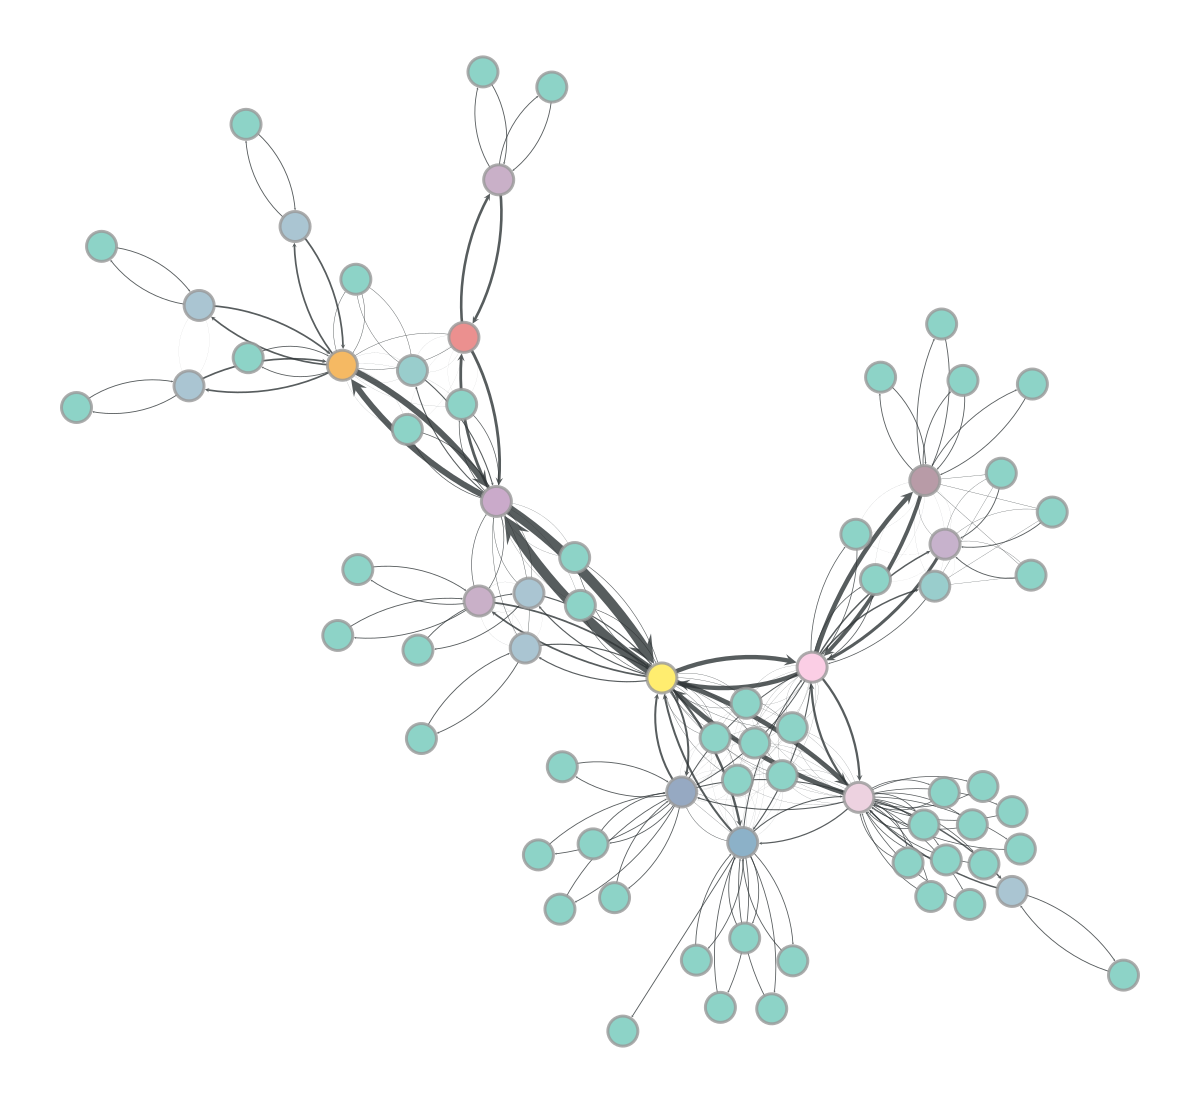

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f95795258e0, at 0x7f9579532490>

In [62]:
path = os.environ["OUT"] + "/arnold.family.gt"
g = load_graph(path)

bv, be = betweenness(g)
be.a /= be.a.max() / 5
graph_draw(g, vertex_fill_color=bv, edge_pen_width=be, vertex_size=15)

`graph-tool` is a very rich library. Here is a visualization of the hierarchical structure of Arnold's extended family:
> More work with the library is needed to interpret the visualization (not part of this tutorial)

**DO NOT RUN IN GOOGLE COLAB. graph-tool does not install properly**

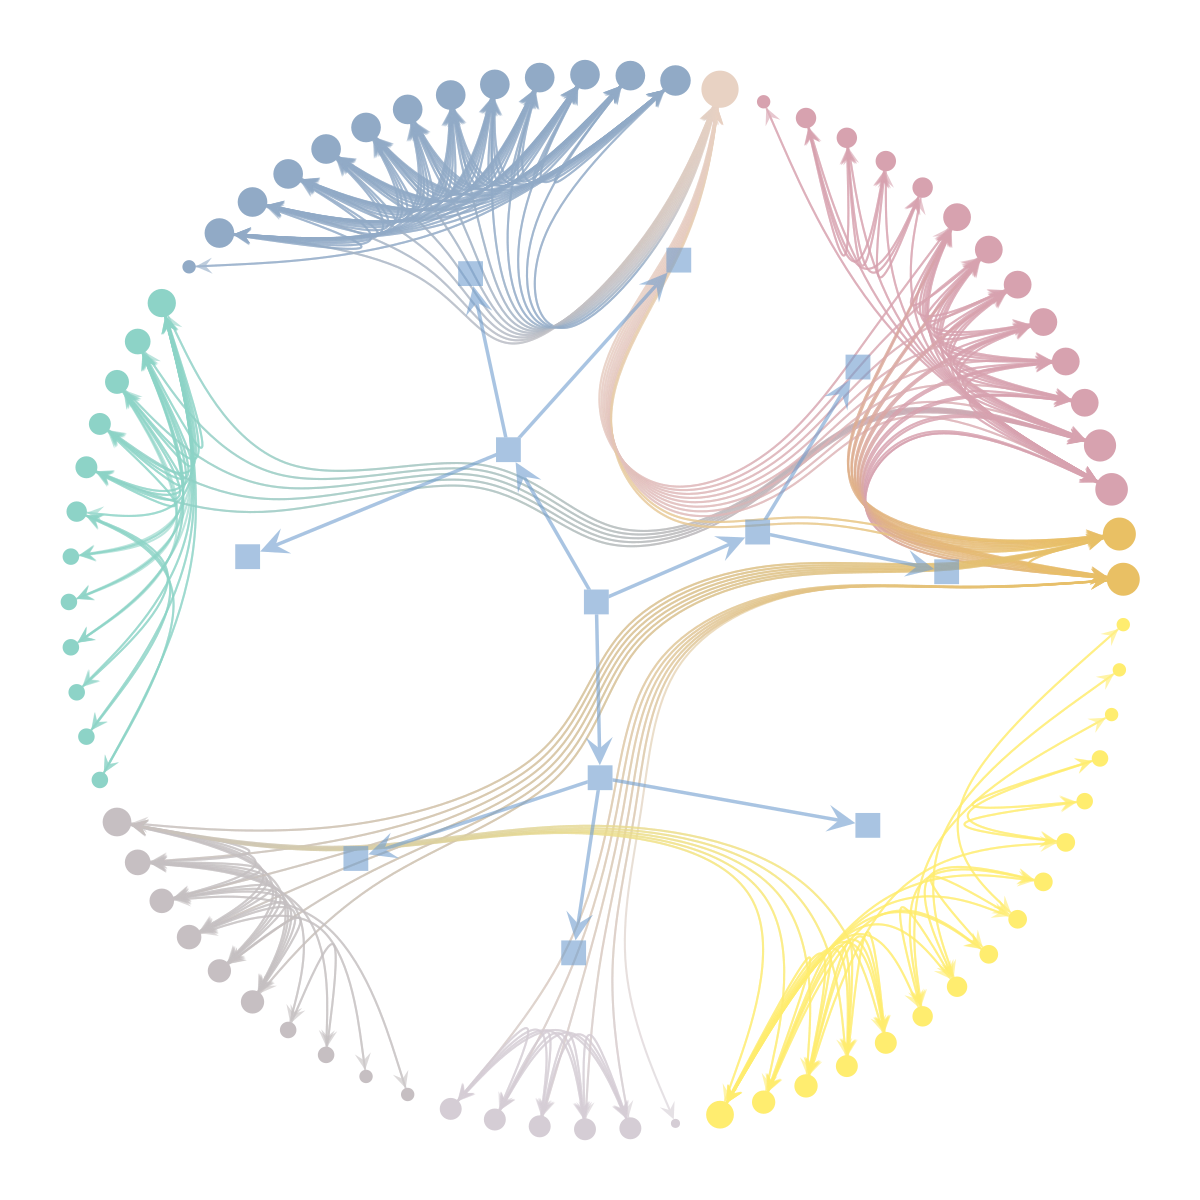

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f95795259a0, at 0x7f957956a5b0>,
 <Graph object, directed, with 85 vertices and 84 edges, at 0x7f9579566070>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f9579566070, at 0x7f95795669a0>)

In [63]:
path = os.environ["OUT"] + "/arnold.family.gt"
g = load_graph(path)

state = minimize_nested_blockmodel_dl(g)
draw_hierarchy(state)

### Summary of this section:
In this section we:
- Uses the `paths` command to find paths between pairs of nodes.
- Used the `export-gt` command to export a KG to `graph tool` format.
- Used `graph tool` to compute betweeness centrality and visualize a KG.

## Computing connected components
In this section we will find the connected components of the tutorial graph and clean up the graph to remove isolated small components.

The KGTK command `connected-components` finds the connected components of a graph, and outputs a new graph that records the connected component that each item belongs to.

In [64]:
kgtk("""
    connected-components -i $item
        --minimum-cluster-size 1
        --undirected 
        -o $TEMP/item.connected_components.tsv
""")

The `connected-components` command outputs the connected components as a graph:

In [65]:
!head $TEMP/item.connected_components.tsv

node1	label	node2
Q616342	connected_component	CLUS4XI69VtenTCbHUKSPaVsaQ==
Q7560691	connected_component	CLUS4XI69VtenTCbHUKSPaVsaQ==
Q11445559	connected_component	CLUSAHfoFvXvhcEZd73lj1z4Bw==
Q11524722	connected_component	CLUSAHfoFvXvhcEZd73lj1z4Bw==
Q91096397	connected_component	CLUSC4L7DB9+AA0px63bXGxYJA==
Q91097216	connected_component	CLUSC4L7DB9+AA0px63bXGxYJA==
Q78607259	connected_component	CLUSCv46LgpNynxBUfoaweda7w==
Q78607418	connected_component	CLUSCv46LgpNynxBUfoaweda7w==
Q17239842	connected_component	CLUSETikQPaem8mOa44EYJ4hWQ==


Find the sizes of each of the connected components using an aggregation query:

In [66]:
kgtk("""
    query -i $TEMP/item.connected_components.tsv
        --match '
            (item)-[]->(component)'
        --return 'distinct component as node1, count(distinct item) as node2'
""")

,node1,node2
0,CLUS4XI69VtenTCbHUKSPaVsaQ==,2
1,CLUSAHfoFvXvhcEZd73lj1z4Bw==,2
2,CLUSC4L7DB9+AA0px63bXGxYJA==,2
3,CLUSCv46LgpNynxBUfoaweda7w==,2
4,CLUSETikQPaem8mOa44EYJ4hWQ==,2
5,CLUSMsI+YaR2hce5HnpP/rq9TQ==,2
6,CLUSNf+5YYA4pq2TcKQzVUbL4A==,2
7,CLUSWhhjZiPd9C8l80phkFJu6Q==,2
8,CLUSiSfL49aiC4iMlarD0N2ONg==,2
9,CLUSnhDzMpk859X1mzkDWfSLBg==,65994


There is one large cluster and several small isolated clusters. We want to keep the large cluster, so we select the nodes that belong to the large cluster:

In [67]:
kgtk("""
    query -i $TEMP/item.connected_components.tsv
        --match '
            (item)-[]->(:`CLUSnhDzMpk859X1mzkDWfSLBg==`)'
        --return 'distinct item as node1'
    / add-labels
""")

,node1,node1;label
0,P10,'video'@en
1,P1000,'record held'@en
2,P1001,'applies to jurisdiction'@en
3,P1004,'MusicBrainz place ID'@en
4,P1005,'Portuguese National Library ID'@en
...,...,...
65989,Q999726,'Dale Van Every'@en
65990,Q999734,'Albert Lasker Award for Basic Medical Researc...
65991,Q99975457,'Faculty of Law of the Károli Gáspár Universit...
65992,Q999763,'University of Paris 1 Pantheon-Sorbonne'@en


Store the large cluster graph in a file (`large-cluster.tsv`) so that we can use it in queries:
> In this example we don't give the graph an alias; instead, we use the path where the graph is stored as an input to the `query` command. KGTK will load the graph in the cache database, and reuse it in subsequent queries:

In [68]:
kgtk("""
    query -i $TEMP/item.connected_components.tsv
        --match '
            (item)-[]->(:`CLUSnhDzMpk859X1mzkDWfSLBg==`)'
        --return 'distinct item as node1'
    -o $TEMP/large-cluster.tsv
""")

Now we want to subset the `item` graph to keep the edges that connect nodes in the large cluster, and discard the edges in the small clusters.
We do this in a query that selects all edges from the `item` graph, as long as both nodes in the edge are in the `node1` position in the `large-cluster.tsv` graph.
> Note that the `large-cluster` graph consists of a set of nodes stored in `node1`, and the graph has no edges. The `query` command can use graphs with no edges using the shorthand `cluster: (n1)`

In [69]:
%%time
kgtk("""
    query -i $TEMP/large-cluster.tsv -i item
        --match '
            item: (n1)-[l]->(n2),
            cluster: (n1),
            cluster: (n2)'
        --return 'distinct n1 as node1, l.label as label, n2 as node2, l as id'
""")

CPU times: user 2.23 s, sys: 403 ms, total: 2.63 s
Wall time: 4.49 s


,node1,label,node2,id
0,P10,P31,Q18610173,P10-P31-Q18610173-85ef4d24-0
1,P1000,P31,Q18608871,P1000-P31-Q18608871-093affb5-0
2,P1001,P1855,Q11696,P1001-P1855-Q11696-cdbf391b-0
3,P1001,P1855,Q12371988,P1001-P1855-Q12371988-12c10bc0-0
4,P1001,P1855,Q181574,P1001-P1855-Q181574-7f428c9b-0
...,...,...,...,...
393699,Q999763,P463,Q868940,Q999763-P463-Q868940-d7659dce-0
393700,Q99979573,P131,Q47164,Q99979573-P131-Q47164-c6e86b16-0
393701,Q99979573,P17,Q30,Q99979573-P17-Q30-aa56b597-0
393702,Q99979573,P30,Q49,Q99979573-P30-Q49-ac39cd28-0


Compare the number of edges of our new graph consisting of the large connected component with the number of edges in the original graph. 
We use the Unix `wc` command to count the number of edges in the original `item` graph:

In [70]:
!zcat< $item | wc -l

  393717


The original graph had a few more edges, so looks like our query did the job. Store the large cluster graph in a file so that we can visualize it:

In [71]:
%%time
kgtk("""
    query -i $TEMP/large-cluster.tsv -i item
        --match '
            item: (n1)-[l]->(n2),
            cluster: (n1),
            cluster: (n2)'
        --return 'distinct n1 as node1, l.label as label, n2 as node2, l as id'
    / compact
    -o $OUT/item.large-cluster.tsv
""")

CPU times: user 7.05 ms, sys: 19.2 ms, total: 26.3 ms
Wall time: 9.24 s


### Visualization of the large connected component

To compute the visualization, use the `export-gt` to export the large connected component to `graph-tool format`:

In [ ]:
!kgtk export-gt -i $OUT/item.large-cluster.tsv -o $OUT/item.large-cluster.gt

The following code loads the graph in `graph-tool` and computes the visualization. It takes 3 minutes to compute the layout and render the visualization, so the code is commented out. An image of the visualization appears below.

```
%%time
path = os.environ["OUT"] + "/item.large-cluster.gt"
g = load_graph(path)

pos = sfdp_layout(g)
graph_draw(g, pos=pos, output_size=(1000, 1000))
```

Visualization of the large connected component of the tutorial graph (393,704 edges). The visualization illustrates the process we used to build the graph: we started at the `Arnold Schwarzenegger (Q2685)` and did a breath first expansion for 3 levels. Then we did a depth-first starting from the nodes representing classes to find the complete closure of the classes.

![Visualization of the tutorial graph](https://github.com/usc-isi-i2/kgtk-tutorial-files/blob/main/media/arnold-graph-vsualization.png?raw=true)

> The following code computes betweeness centrality of the large connected component and visualizes it

```
%%time
path = os.environ["OUT"] + "/item.large-cluster.gt"
g = load_graph(path)

bv, be = betweenness(g)
be.a /= be.a.max() / 5
graph_draw(g, vertex_fill_color=bv, edge_pen_width=be, output_size=(1500, 1500))
```

### Summary of this section
In this section we:
- Computed the connected components of the tutorial graph using the `connected-components` command.
- Discovered that the tutorial graph contained one large cluster (expected) and a few isolated tiny clusters (unexpected).
- Created a new graph discarding the tiny isolated clusters.
- Visualized the large connected component.